# VAEでクラス識別ができないか検討してみる
- 目的
    - 生成モデルでクラス識別できるものかを確かめてみる
- 目標
    - VAEを使って2クラス分類タスクを解いてみる
- 手段
    - mnist手書き数字の任意の2文字を使う
    - 潜在空間を2次元にして可視化できるようにする
    - $p(z|C_K)$をガウス関数でパラメトリックにモデル化できるかやってみる
    - $p(C_k|z)$をベイズの公式で計算できるかやってみる

In [21]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import mse, binary_crossentropy

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [23]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [24]:
# ラベルに対応するインデックスを取得する
indices_train = [np.where(y_train == i)[0] for i in range(10)]
indices_test = [np.where(y_test == i)[0] for i in range(10)]

# データをラベルごとに分割する
data_train = [x_train[indices_train[i]] for i in range(10)]
data_test  = [x_test[indices_test[i]] for i in range(10)]

In [25]:
latent_dim = 2
batch_size = 128
epochs = 10

In [26]:
# エンコーダーの定義
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(512, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# 潜在変数のサンプリング関数の定義
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=(tf.keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + tf.keras.backend.exp(z_log_var) * epsilon

# 潜在変数のサンプリング関数を使用して、潜在変数zを生成します。
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# デコーダーの定義
decoder_input = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(256, activation='relu')(decoder_input)
x = Dense(512, activation='relu')(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# エンコーダーとデコーダーを結合してVAEモデルを作成します。
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [27]:
reconstruction_loss = mse(inputs, outputs) * original_dim
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [28]:
vae.fit(data_train[0],
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/10


2023-11-25 12:49:21.861337: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0b2f8d8bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 12:49:21.861478: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2023-11-25 12:49:21.894792: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 12:49:21.955205: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1700916562.115144   32256 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/47 [===========================>..] - ETA: 0s - loss: 75.0127

2023-11-25 12:49:24.043718: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.
2023-11-25 12:49:24.299995: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


47/47 [==============================] - 6s 35ms/step - loss: 73.5312 - val_loss: 74.1775
Epoch 2/10
47/47 [==============================] - 1s 20ms/step - loss: 50.0085 - val_loss: 72.2994
Epoch 3/10
47/47 [==============================] - 1s 23ms/step - loss: 43.6220 - val_loss: 72.4787
Epoch 4/10
47/47 [==============================] - 1s 23ms/step - loss: 41.5103 - val_loss: 69.6803
Epoch 5/10
47/47 [==============================] - 1s 24ms/step - loss: 40.2079 - val_loss: 70.3229
Epoch 6/10
47/47 [==============================] - 1s 23ms/step - loss: 36.0001 - val_loss: 68.6525
Epoch 7/10
47/47 [==============================] - 1s 22ms/step - loss: 34.9127 - val_loss: 69.6713
Epoch 8/10
47/47 [==============================] - 1s 23ms/step - loss: 34.2836 - val_loss: 68.8193
Epoch 9/10
47/47 [==============================] - 1s 22ms/step - loss: 33.7365 - val_loss: 69.1440
Epoch 10/10
47/47 [==============================] - 1s 21ms/step - loss: 33.2787 - val_loss: 72.0785


1/1 [==============================] - 0s 16ms/step


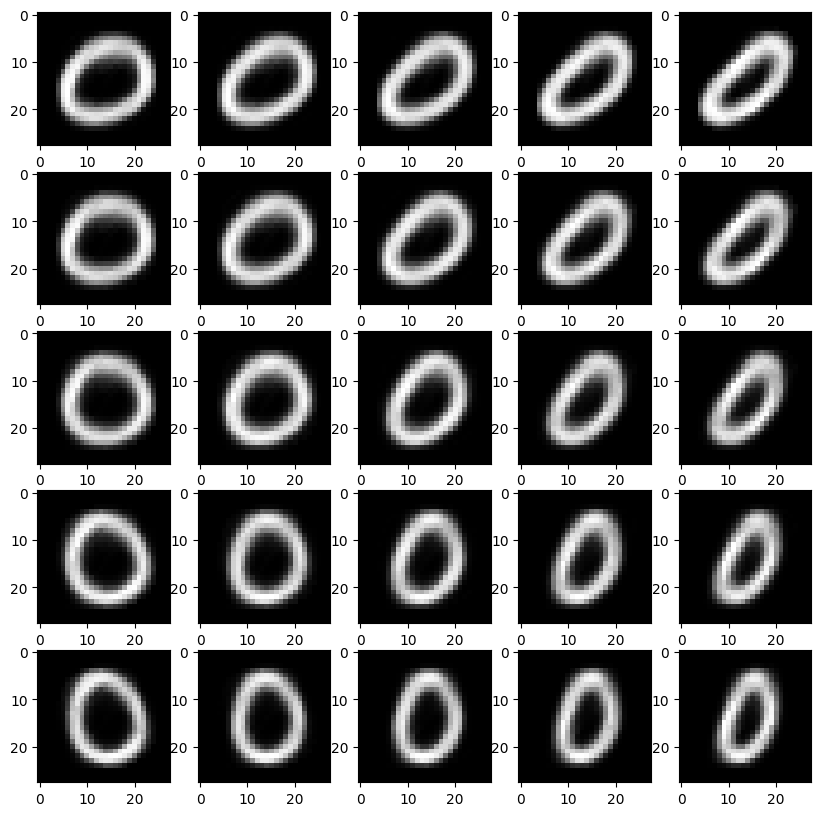

In [34]:
x = np.arange(-1, 1.1, 0.5)
y = np.arange(-1, 1.1, 0.5)

xx, yy = np.meshgrid(x, y)
data = np.array([xx.ravel(), yy.ravel()]).T

list_generated_image = []
for i in data:
    list_generated_image.append(decoder.predict(i.reshape(1,2)))

fig, axs = plt.subplots(5, 5, figsize=(10, 10))
cnt=0
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(list_generated_image[cnt].reshape(28,28), cmap="gray")
        cnt+=1
plt.show()

In [36]:
# データをエンコーダーに入力して、平均、分散、サンプルを得ます。
z_mean, z_log_var, z = encoder.predict(data_test[0], batch_size=batch_size)

print(z_mean)
print(z_log_var)
print(z)

8/8 [==============================] - 0s 12ms/step
[[ 0.25405556  0.35265702]
 [-0.44137466  0.2245972 ]
 [-0.20949735  0.8209059 ]
 ...
 [ 0.7757583  -0.558488  ]
 [-0.21981002 -0.16444284]
 [ 0.10726032 -0.9814722 ]]
[[-2.4520793 -2.0698118]
 [-2.8948784 -2.4707813]
 [-2.5158525 -1.8361615]
 ...
 [-2.3172693 -2.0569963]
 [-2.8505256 -2.352984 ]
 [-2.413485  -1.9506414]]
[[ 0.31658822  0.50421596]
 [-0.53103954  0.28606197]
 [-0.29425964  0.7696911 ]
 ...
 [ 0.7273462  -0.5195023 ]
 [-0.19679016 -0.27278662]
 [ 0.07042392 -1.1235085 ]]


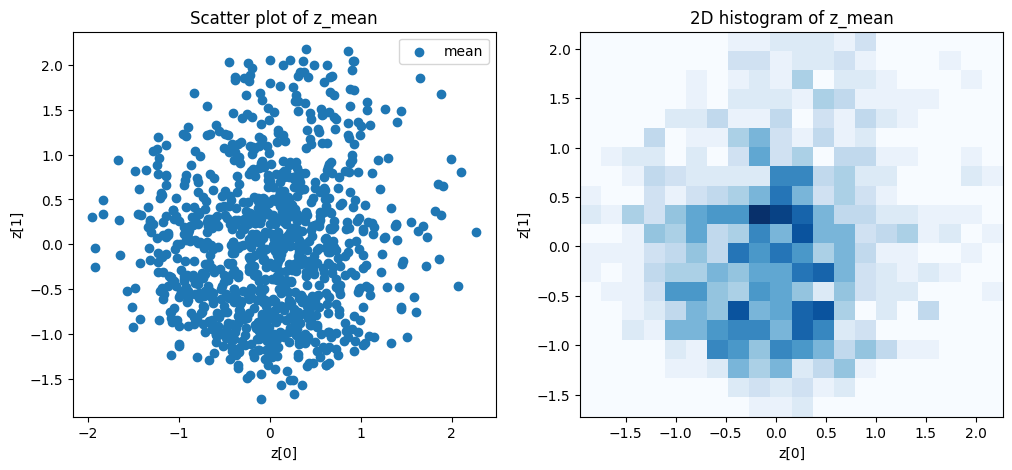

In [43]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(z_mean[:, 0], z_mean[:, 1], alpha=1, label='mean')
axs[0].legend()
axs[0].set_xlabel("z[0]")
axs[0].set_ylabel("z[1]")
axs[0].set_title("Scatter plot of z_mean")

axs[1].hist2d(z_mean[:, 0], z_mean[:, 1], bins=20, cmap='Blues')
axs[1].set_xlabel("z[0]")
axs[1].set_ylabel("z[1]")
axs[1].set_title("2D histogram of z_mean")

plt.show()
